自注意力是一种更有效的进行输入表示的机制。它允许序列中的每个位置在计算它在序列中的表示时，都能关注序列中的所有位置。通俗来讲，就是每个单词在句子中的含义是由句子中其它单词组成的上下文决定的。

# 一、简单自注意力
## 1.1 单个token的注意力权重
自注意力机制中的自（self）是指注意力权重所要关注的是单一输入序列内部不同位置的联系。作为对比，传统注意力关注的是两个不同序列之间的元素关系。

自注意力的目标是为每个输入token计算一个上下文向量，该向量结合了序列中所有其他输入token的信息。

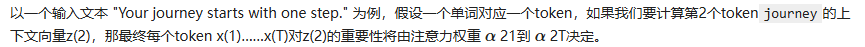
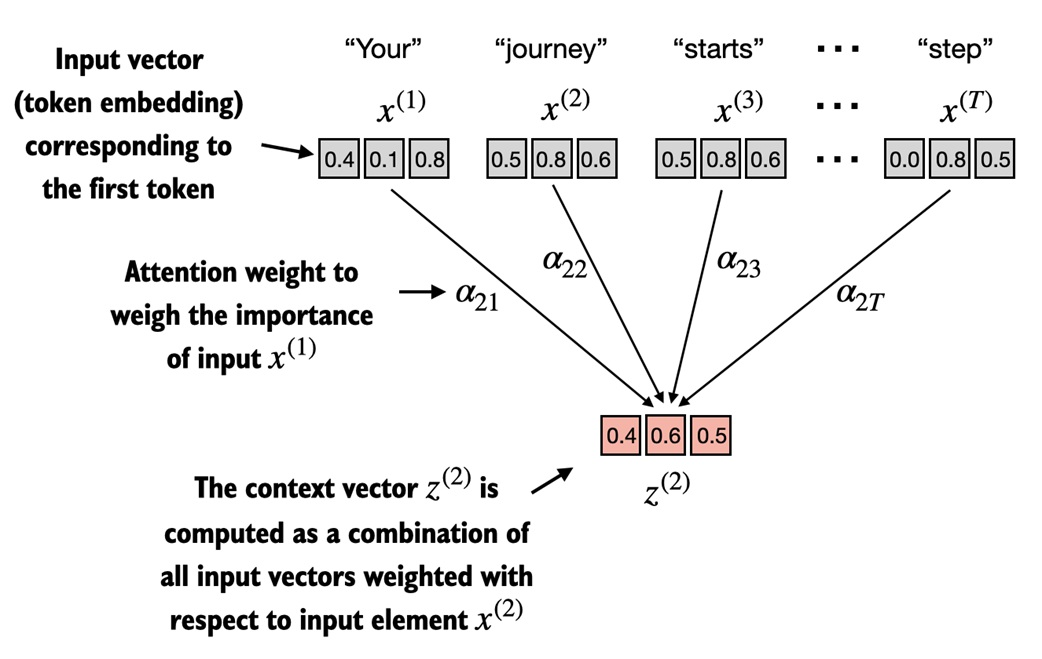

接下来，我们将用代码来演示这个计算的过程。

为了可显示的需要，我们降低了嵌入的维度，我们对每个token采用三维嵌入。

In [1]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
    [0.55, 0.87, 0.66], # journey  (x^2)
    [0.57, 0.85, 0.64], # starts   (x^3)
    [0.22, 0.58, 0.33], # with     (x^4)
    [0.77, 0.25, 0.10], # one      (x^5)
    [0.05, 0.80, 0.55]] # step     (x^6)   
)

1. 计算注意力得分
> 实现自注意力机制的第一步是计算中间变量 ω，这些变量被称为注意力得分。方法是计算 journey 的嵌入向量x(2)与其它token的嵌入向量之间的点积。

注：点积是一个衡量两个向量相似度的数学工具，具体的计算可以认为是两个向量对应位置的元素相乘后求和。以x(1)和x(2)的点积为例，就是0.43 * 0.55 + 0.15 * 0.87 + 0.89 * 0.66 = 0.9544。

In [2]:
query = inputs[1]
atten_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    atten_scores_2[i] = torch.dot(query, x_i)

atten_scores_2

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

那通过点积计算的这些数值有什么含义呢？

在自注意力机制中，点积用于衡量序列中各token之间的关注程度，点积值越高，两个token之间的相似性和注意力得分就越高。

2. 分数归一化

归一化就是将注意力得分中的每个数值进行变换，目标是各项数值的总和为1。归一化的最简单做法是每个元素除以所有元素之和，如下所示：

In [5]:
normalized_scores_2 = atten_scores_2/atten_scores_2.sum()
normalized_scores_2

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

但实际场景中，更推荐使用softmax进行归一化，与上面我们直接采用元素本身进行运算不同，softmax先对所有元素进行指数运算。

In [6]:
def softmax_normalize(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

atten_weights_2 = softmax_normalize(atten_scores_2)
atten_weights_2, atten_weights_2.sum()

(tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581]), tensor(1.))

使用softmax进行归一化的好处在于：指数运算确保了所有注意力得分为正，这意味着输出可以被解释为概率，高数值代表更大的重要性。

3. 现在我们已经得到了注意力权重w, 下一步是将每个嵌入的向量 x(i) 与相应的注意力权重相乘，然后将结果向量求和，计算出上下文向量 z(2)。

In [7]:
context_vec_2 = torch.empty(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += atten_weights_2[i] * x_i
context_vec_2

tensor([-1.8891e+26,  1.2539e+00,  5.6831e-01])

## 2.2 所有token的注意力权重

上面对第2个token journey计算了上下文向量，下面会对代码作一些修改，以将计算过程扩展至所有输入token的注意力权重和上下文向量。

In [8]:
atten_scores = torch.empty(inputs.shape[0], inputs.shape[0])
for i, query in enumerate(inputs):
    for j, x_i in enumerate(inputs):
        atten_scores[i, j] = torch.dot(query, x_i)

atten_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

上面计算过程本质上是inputs矩阵和inputs矩阵的转置相乘，在pytorch中矩阵相乘有更简单的写法：

In [9]:
atten_scores = inputs @ inputs.T
atten_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

pytorch中的这种矩阵乘法运算不仅简洁，而且执行效率也比python中的for循环更高效。

下面对每行的注意力得分进行归一化，使其总和为1。同样，对于归一化也使用pytorch中封装的softmax来代替我们手工编写的softmax。

In [10]:
atten_weights = torch.softmax(atten_scores, dim=1)
atten_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

最后通过矩阵乘法来生成所有的上下文向量，在得到的输出结果中，每一行都包含一个三维的上下文向量。

In [11]:
context_vecs = atten_weights @ inputs
context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

其中，第二行的输出张量[0.4419, 0.6515, 0.5683]与我们上面计算的context_vec_2完全相同，也说明代码计算无误。

到这里，我们就完成了一个简单自注意力的代码演示。接下来，我们将添加可训练的权重，使自己编写的注意力具备可学习性。

# 二、可训练权重的自注意力

## 2.1 初始化权重矩阵

首先，我们定义输入和输出的维度dim_in和dim_out

In [12]:
dim_in = inputs.shape[1]
dim_out = inputs.shape[1]

在前面简单注意力的基础上，引入三个可训练的权重矩阵 Wq、Wk 和 Wv，这三个矩阵会用于将嵌入的输入向量 x(i) 投影为查询向量Q、键向量K和值向量V。

In [13]:
torch.manual_seed(123)

Wq = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)
Wk = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)
Wv = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)

> 注：这里将requires_grad设为False只是为了显示矩阵结果时更清晰，如果要将这些权重用于模型训练，则需要将require_grads设为True。

## 2.2 计算Q、K、V向量
同样，我们先以第二个token journey的输入向量x(2)作查询向量，来计算与其对应的查询（q）、键（k）和值（v）向量。

In [14]:
x_2 = inputs[1]

q_2 = Wq @ x_2
k_2 = Wk @ x_2
v_2 = Wv @ x_2

q_2, k_2, v_2

(tensor([0.7784, 1.0150, 0.2858]),
 tensor([1.1273, 0.4215, 0.8702]),
 tensor([1.3481, 1.5287, 0.9069]))

In [15]:
x_2.shape, Wq.shape

(torch.Size([3]), torch.Size([3, 3]))

> 注：前面简单自注意力的实现代码中，我们是直接将嵌入向量自身x_i作为q、k、v，而这里的q、k、v三个向量是通过输入向量x_i与三个权重矩阵计算而来，这样的好处是能通过模型训练让这个自注意力不断进化

尽管只是计算一个token的上下文向量z(2)，但我们仍然需要所有token的键向量k和值向量v，因为查询向量q_2需要与序列中所有token的k向量和v向量运算，才能得到x_2的注意力权重和上下文向量。

In [16]:
keys = inputs @ Wk
values = inputs @ Wv

keys, values

(tensor([[0.6813, 0.2706, 1.0793],
         [0.7305, 0.4227, 1.1993],
         [0.7355, 0.4227, 1.1901],
         [0.3363, 0.2225, 0.6077],
         [0.6184, 0.3038, 0.6909],
         [0.3178, 0.2383, 0.7426]]),
 tensor([[0.4976, 0.9655, 0.7614],
         [0.9074, 1.3518, 1.5075],
         [0.8976, 1.3391, 1.4994],
         [0.5187, 0.7319, 0.8493],
         [0.4699, 0.7336, 0.9307],
         [0.6446, 0.9045, 0.9814]]))

## 2.3 计算注意力得分
如同前面的简单自注意力实现一样，注意力得分是一个点积运算，有所不同的是，我们不再直接计算输入元素，而是经过权重矩阵变换过的查询向量q、键向量k和值向量v。
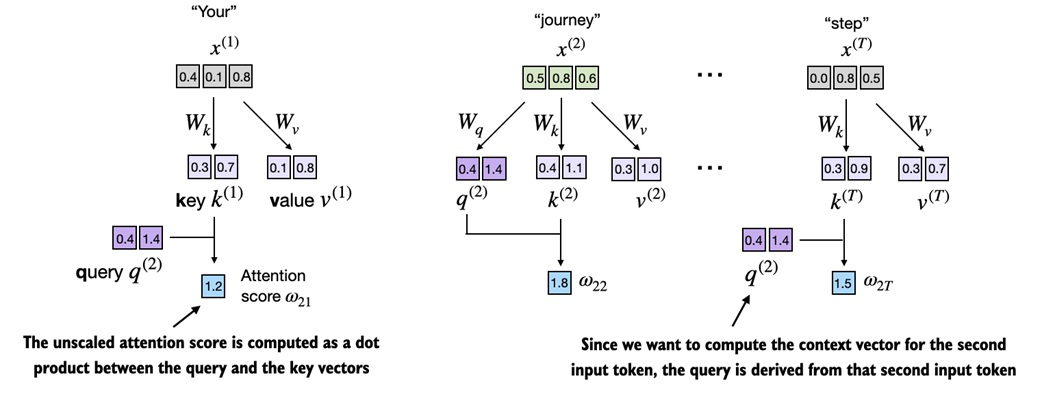

In [18]:
atten_scores_2 = q_2 @ keys.T
atten_scores_2

tensor([1.1133, 1.3403, 1.3416, 0.6613, 0.9871, 0.7014])

> 注：点积操作是让查询向量q_2与keys中的每个行向量运算，由于keys是一个6行3列的矩阵，对keys进行转置变换后形状变为3行6列，这个点积操作就可以变换成q_2与keys.T的矩阵乘法运算，即q_2与keys.T中的每个列向量相乘。

## 2.3 计算注意力权重
从上面可以知道，注意力得分到注意力权重的变换是通过softmax进行归一化运算。与之前不同的是，这里我们会引入缩放点积来计算注意力，具体操作就是在softmax之前，先将注意力得分除以键的嵌入维度的平方根来缩放注意力得分。

注：平方根可以表示成以1/2为底的冥运算，即嵌入维度的0.5次方。除以键的嵌入维度的平方根能够嵌入维度自适应调整缩放比例。

In [19]:
dim_k = keys.shape[-1]
atten_weights_2 = torch.softmax(atten_scores_2/dim_k ** 0.5, dim = -1)
atten_weights_2

tensor([0.1733, 0.1976, 0.1978, 0.1335, 0.1612, 0.1366])

> 缩放点积的原因在于：在类似GPT一样的大语言模型中，嵌入维度大到接近上千，大的嵌入维度在进行点积操作时也会产生大的点积和，而较大的点积应用softmax函数后，会在反向传播过程中产生非常小的梯度，这些小的梯度会减缓学习速度，甚至训练停滞。

> softmax是基于指数运算的，指数运算会对点积和进行几何倍数的放大，最终导致softmax的运算结果趋近于一个独热编码，即只有一个趋近于1，其它都接近0。在进行反向传播时，除了独热的元素外，其它元素的梯度都趋近于0，导致梯度消失。

通过嵌入维度的平方根进行缩放的这种注意力机制也被称为缩放点积注意力。

> 区分权重参数与注意力权重：我们上面提到的Wq、Wk、Wv三个权重矩阵都属于权重参数，它是整个神经网络中的通用概念，是可以被训练的。而注意力权重只是Attention机制中的一个动态变量，它决定了输入序列中的不同token分别在多大程度上影响上下文向量。

## 2.4 计算上下文向量
得到了注意力权重后，我们通过对所有值向量加权求和就能计算出上下文向量，而注意力权重就是衡量每个值向量重要性的权重因子。

In [21]:
context_vec_2 = atten_weights_2 @ values
context_vec_2

tensor([0.6761, 1.0388, 1.1239])

整个计算如图
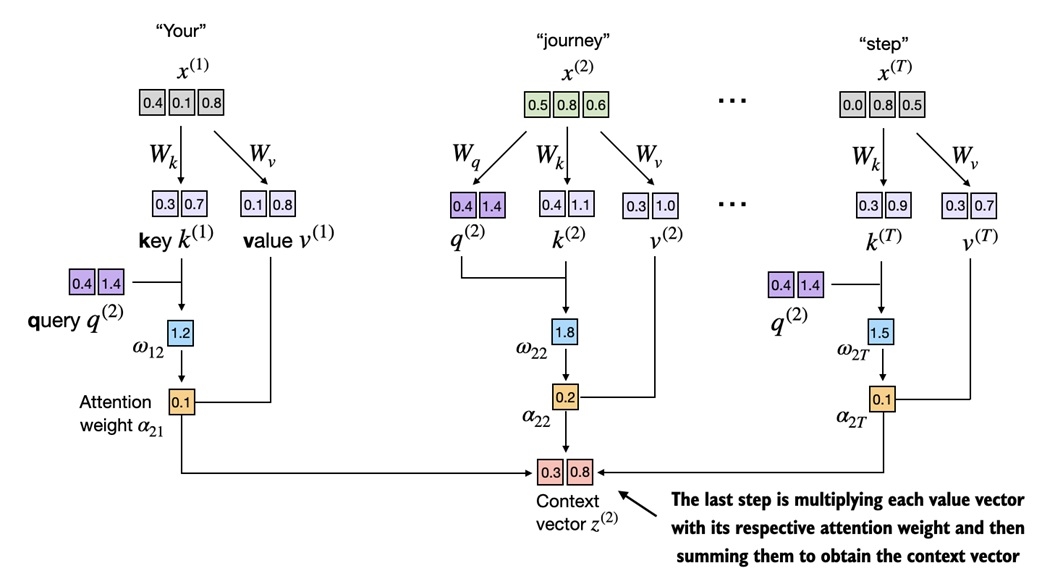

# 三、实现selfAttention类
上面逐步计算自注意力的过程是为了理解和展示，实际应用中，会把上面的代码整合到一个python类中以便高效使用。

In [24]:
from torch import nn


class SelfAttention(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.dim_out = dim_out
        self.Wq = nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=True)
        self.Wk = nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=True)
        self.Wv = nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=True)
        
    def forward(self, x):
        q = x @ self.Wq
        k = x @ self.Wq
        v = x @ self.Wv
        
        atten_scores = q @ k.T
        atten_weights = torch.softmax(atten_scores / self.dim_out ** 0.5, dim=-1)
        context_vecs = atten_weights @ v
        return context_vecs

In [25]:
torch.manual_seed(123)
atten = SelfAttention(inputs.shape[-1], inputs.shape[-1])
atten(inputs)

tensor([[0.6749, 1.0282, 1.1193],
        [0.7013, 1.0611, 1.1616],
        [0.7007, 1.0604, 1.1607],
        [0.6829, 1.0375, 1.1315],
        [0.6774, 1.0316, 1.1237],
        [0.6900, 1.0462, 1.1427]], grad_fn=<MmBackward0>)

> 可以看到，第二行的上下文向量与我们上面手动计算的context_vec_2(tensor([0.6864, 1.0577, 1.1389]))是完全相同。

** 小结 **：本节从一个简单文本的三维嵌入开始，一步一步复现了自注意力的详细计算过程，而后从简单自注意力逐步过滤到可训练权重的自注意力，从基础的矩阵计算逐步过渡到pytorch的高级API，最后将这个计算过程封装为一个组件以备复用。下一节，我们将结合因果关系和多头元素对自注意机制进行改进。